# Lab 5: **Invariance** and **Equivariance** at different layers of a *CNN*

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2023_Lab_05_CNN_Invariance_Equivariance.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#### Overview of the *Lab*

In the following *Lab*, we will study the *invariance* and *equivariance* properties of specific layers within a *CNN*.

Recall the definitions -- respectively -- of **invariance** and **equivariance** of (the result of) function $f$ with respect to transformation (expressed in the form of an operator) $P_{\alpha}$ parametrized by $\alpha$:

- *Invariance*: $f(P_{\alpha} x) = f(x)\;\;\;\; \forall\alpha$
- *Equivariance*: $f(P_{\alpha} x) = P_{\alpha} f(x)\;\;\;\; \forall\alpha$

According to theory, the training of a *CNN* with pooling should lead to a network whose:

- *Convolutional* layers are *equivariant* to translation;
- *Fully Connected* layers are *invariant* to translation.

Due to the specific structure of convolutional layers, it is possible to show that the *equivariance* property gives rise to permuted activations in response to translation of inputs.

In [4]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

The following *CNN* model is given, whose output -- for your convenience -- is a tuple, composed of the actual output of the network, the activation tensor after the second *convolutional* layer, and the activation tensor after the first *fully-connected* layer:

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=2)
        self.fc1 = nn.Linear(729, 10)

    def forward(self, x):
        x = self.conv1(x)
        conv2repr = x.clone().detach()
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        fc1repr = x.clone().detach()
        x = F.log_softmax(x, dim=1)
        return x, conv2repr, fc1repr

Taking inspiration from previous *Labs*:

1. Train the model on the (non-augmented) *MNIST* dataset;
2. Prepare a test dataset composed of pairs of mutually traslated images;
3. Extract the activations of layers `conv2` and `fc1` and check whether they respect the invariance/equivariance property.

**Hint**: To test for *equivariance*, it may be useful to notice that **sorting** is invariant to permutations!

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [11]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

def train(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output, _, _ = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs} completed')

train(model, train_loader, optimizer, criterion)

Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


In [21]:
def translate_image(image, dx, dy):
    return torch.roll(image, shifts=(dy, dx), dims=(2, 3))

def prepare_translated_dataset(dataset, dx=-1, dy=-1):
    translated_dataset = []
    for image, label in dataset:
        translated_image = translate_image(image.unsqueeze(0), dx, dy)
        translated_dataset.append((image, translated_image.squeeze(0), label))
    return translated_dataset

translated_test_dataset = prepare_translated_dataset(test_dataset)
translated_test_loader = DataLoader(translated_test_dataset, batch_size=1000, shuffle=False)

FC1 layer invariance (mean absolute difference): 2.562991
Conv2 layer equivariance (mean absolute difference of sorted activations): 0.000041


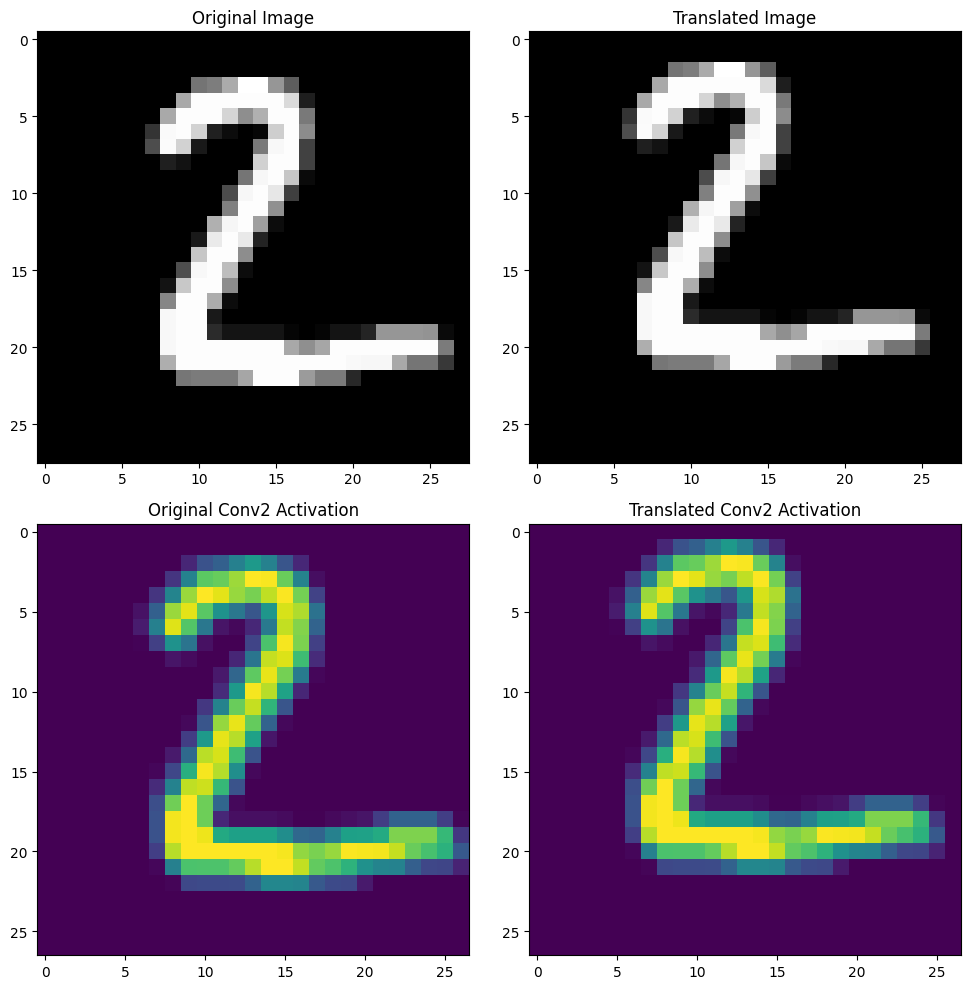

In [22]:
def test_invariance_equivariance(model, loader):
    model.eval()
    with torch.no_grad():
        for batch in loader:
            original, translated, _ = batch
            
            # Forward pass
            original_output, original_conv2, original_fc1 = model(original)
            translated_output, translated_conv2, translated_fc1 = model(translated)
            
            # Test invariance of fully connected layer
            fc1_diff = torch.abs(original_fc1 - translated_fc1).mean()
            print(f"FC1 layer invariance (mean absolute difference): {fc1_diff:.6f}")
            
            # Test equivariance of convolutional layer
            original_conv2_sorted = original_conv2.view(original_conv2.size(0), -1).sort(dim=1)[0]
            translated_conv2_sorted = translated_conv2.view(translated_conv2.size(0), -1).sort(dim=1)[0]
            conv2_diff = torch.abs(original_conv2_sorted - translated_conv2_sorted).mean()
            print(f"Conv2 layer equivariance (mean absolute difference of sorted activations): {conv2_diff:.6f}")
            
            # Visualize some examples
            visualize_examples(original[1], translated[1], original_conv2[1], translated_conv2[1])
            
            break  # Process only one batch for demonstration

def visualize_examples(original, translated, original_conv2, translated_conv2):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(original.squeeze(), cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 1].imshow(translated.squeeze(), cmap='gray')
    axes[0, 1].set_title('Translated Image')
    axes[1, 0].imshow(original_conv2.squeeze(), cmap='viridis')
    axes[1, 0].set_title('Original Conv2 Activation')
    axes[1, 1].imshow(translated_conv2.squeeze(), cmap='viridis')
    axes[1, 1].set_title('Translated Conv2 Activation')
    plt.tight_layout()
    plt.show()

test_invariance_equivariance(model, translated_test_loader)

FC layers are not invariant for small translations because there is no pooling in the model!